In [1]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    assert int(torch.__version__.split(".")[0])>1 or (int(torch.__version__.split(".")[0])>2 and int(torch.__version__.split(".")[1]) >= 12), "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    # print(f"torch version: {torch.__version__}")
    # print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0
torchvision version: 0.18.0


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/home/joseph/miniconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper (4096) but it's because we're starting small # we can always scale up later

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

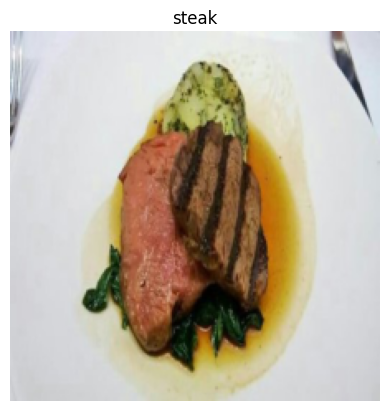

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);


In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height*width)/patch_size**2)
number_of_patches

196

In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)") # 2D image flattened into patches = 1D sequence of patches

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


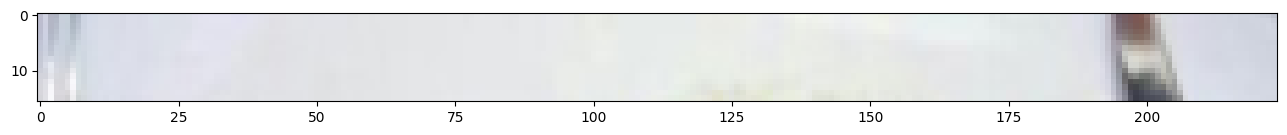

In [12]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

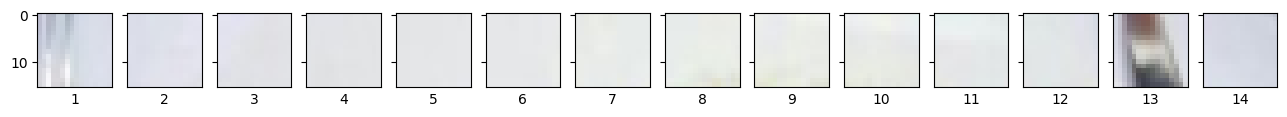

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,                    # one column for each patch
                        sharex=True, sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
#   axs[i].set_yticks([])
       # keep height index constant, alter the width index

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches : 196.0  
Patch size: 16 pixels x 16 pixels


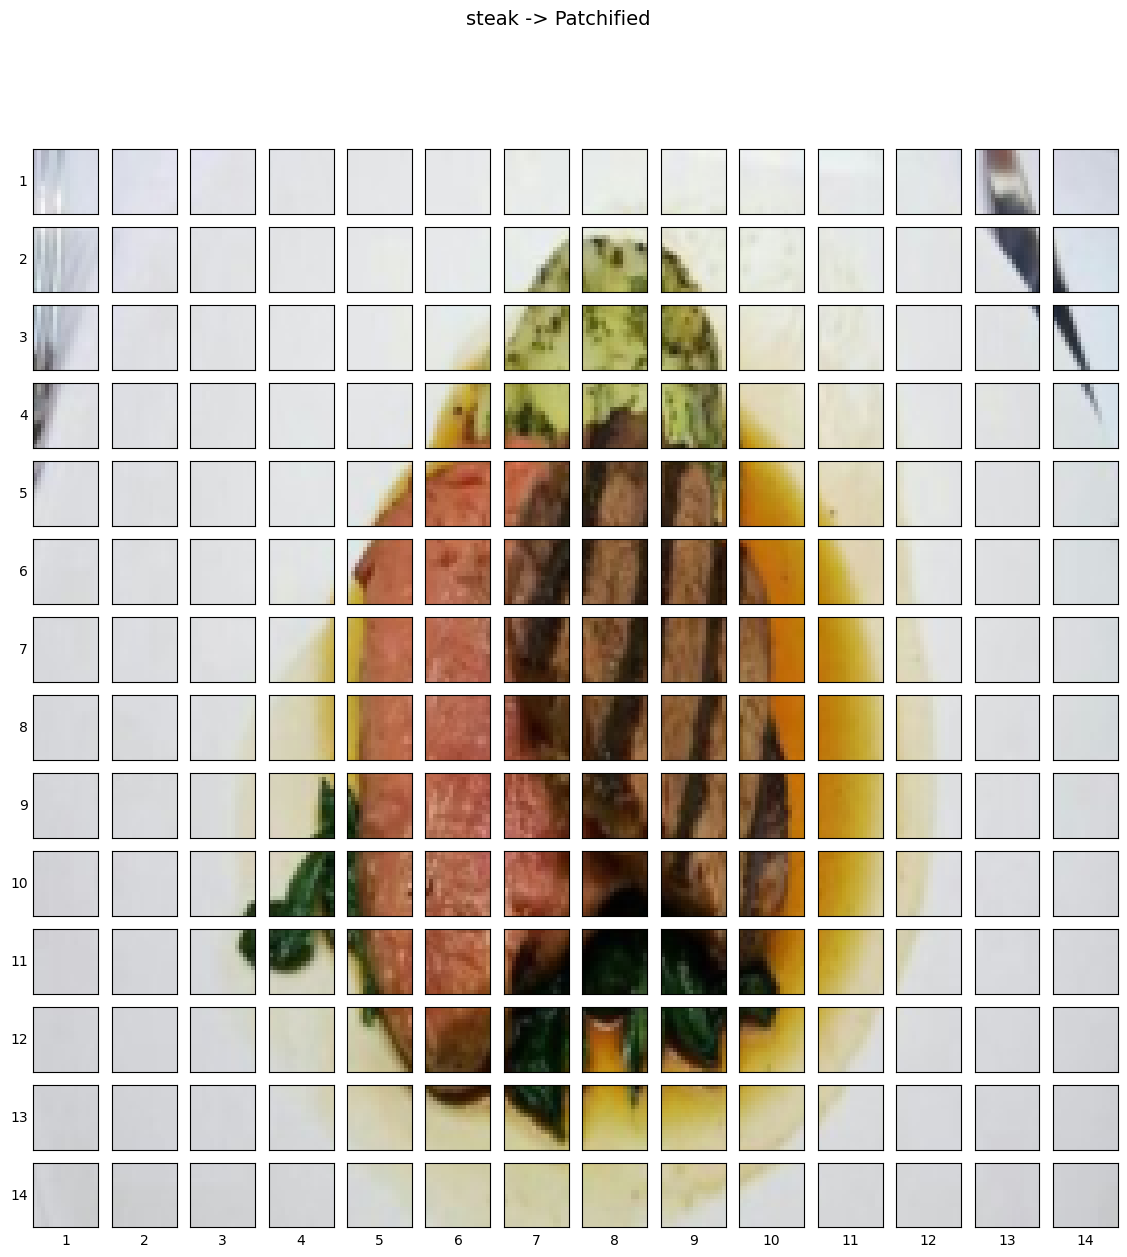

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches : {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
                        # need int not float

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):   # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
      # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
      axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                      patch_width:patch_width+patch_size, # iterate through width
                                      :])# get all color channels

      # Set up label information, remove the ticks for clarity and set labels to outside
      axs[i, j].set_ylabel(i+1,
                           rotation="horizontal",
                           horizontalalignment="right",
                           verticalalignment="center")
      axs[i, j].set_xlabel(j+1)
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])
      axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

In [15]:
# Creating image patches with torch.nn.Conv2d()
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

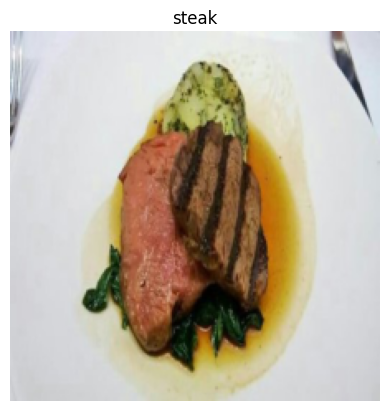

In [16]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [17]:
print(image.shape)
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


In [18]:
image_out_of_conv.requires_grad

True

Showing random convlutional feature maps from indexes: [374, 725, 328, 72, 16]


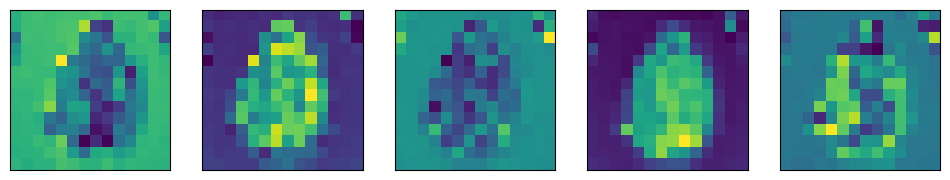

In [19]:
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"Showing random convlutional feature maps from indexes: {random_indexes}") # pick 5 numbers between 0 and the embedding size

fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:,idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(tensor([[[-0.2400, -0.1922, -0.1720, -0.1710, -0.1793, -0.1775, -0.1809,
           -0.1571, -0.1546, -0.1585, -0.1708, -0.1722, -0.0786, -0.1773],
          [-0.1831, -0.1746, -0.1713, -0.1784, -0.1788, -0.1742,  0.0568,
            0.0265, -0.0623, -0.1479, -0.1650, -0.1679, -0.1401, -0.1056],
          [-0.1777, -0.1749, -0.1732, -0.1776, -0.1719, -0.0762,  0.0172,
           -0.1758, -0.1493, -0.1272, -0.1663, -0.1702, -0.1750, -0.4309],
          [-0.2632, -0.1739, -0.1751, -0.1788, -0.1778,  0.1384,  0.0483,
            0.1252,  0.0495, -0.0214, -0.1403, -0.1631, -0.1663, -0.1375],
          [-0.2050, -0.1743, -0.1755, -0.1747,  0.0769, -0.0331,  0.0594,
           -0.0384, -0.0737, -0.0449, -0.0564, -0.1596, -0.1667, -0.1640],
          [-0.1640, -0.1676, -0.1744, -0.1550, -0.0886, -0.0194,  0.0865,
           -0.0715, -0.0416, -0.0776, -0.0577, -0.1453, -0.1658, -0.1637],
          [-0.1667, -0.1672, -0.1646, -0.0774, -0.0106, -0.0611,  0.0501,
            0.0497, -0.0290, -0.

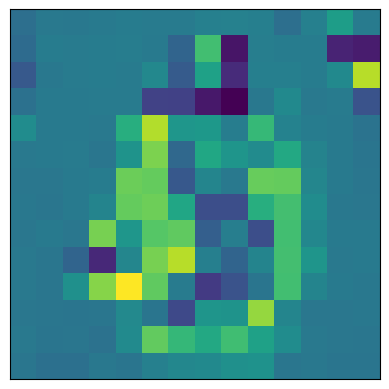

In [20]:
plt.xticks([]), plt.yticks([])

# single feature map (in tensor form)
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad, plt.imshow(image_conv_feature_map.squeeze().detach().numpy())

In [21]:
# Create flatten layer
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,  # flatten feature_map_height (dimension 2)
                           end_dim=3)    # flatten feature_map_width (dimension 3)
flattened_image_out_of_conv = flatten_layer(image_out_of_conv)

flattened_image_out_of_conv.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


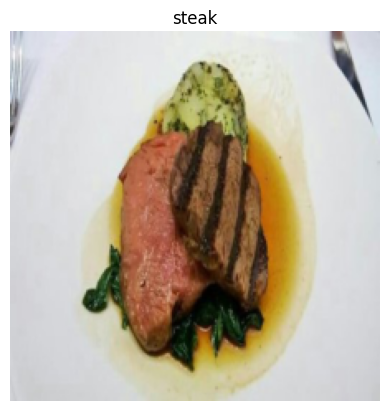

In [22]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [23]:
image_out_of_conv_flattened_reshaped

NameError: name 'image_out_of_conv_flattened_reshaped' is not defined

In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


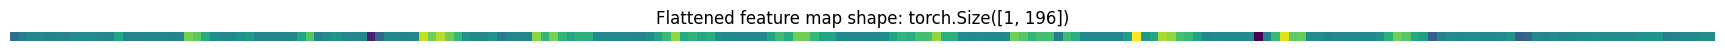

In [27]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [28]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.2400, -0.1922, -0.1720, -0.1710, -0.1793, -0.1775, -0.1809, -0.1571,
          -0.1546, -0.1585, -0.1708, -0.1722, -0.0786, -0.1773, -0.1831, -0.1746,
          -0.1713, -0.1784, -0.1788, -0.1742,  0.0568,  0.0265, -0.0623, -0.1479,
          -0.1650, -0.1679, -0.1401, -0.1056, -0.1777, -0.1749, -0.1732, -0.1776,
          -0.1719, -0.0762,  0.0172, -0.1758, -0.1493, -0.1272, -0.1663, -0.1702,
          -0.1750, -0.4309, -0.2632, -0.1739, -0.1751, -0.1788, -0.1778,  0.1384,
           0.0483,  0.1252,  0.0495, -0.0214, -0.1403, -0.1631, -0.1663, -0.1375,
          -0.2050, -0.1743, -0.1755, -0.1747,  0.0769, -0.0331,  0.0594, -0.0384,
          -0.0737, -0.0449, -0.0564, -0.1596, -0.1667, -0.1640, -0.1640, -0.1676,
          -0.1744, -0.1550, -0.0886, -0.0194,  0.0865, -0.0715, -0.0416, -0.0776,
          -0.0577, -0.1453, -0.1658, -0.1637, -0.1667, -0.1672, -0.1646, -0.0774,
          -0.0106, -0.0611,  0.0501,  0.0497, -0.0290, -0.0831, -0.0816, -0.1645,
          -0.167

In [43]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768):
    
        super().__init__()
        
        self.patch_size = patch_size
        
        # Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # Create a layer to flatten the patches
        self.flatten = nn.Flatten(2,3) # only flatten the feature map dimensions into a single vector

    # Forward Method
    def forward(self, x):
        image_resolution = x.shape[-1] # image resolution check
        assert image_resolution % patch_size == 0, f"Image resolution {image_resolution} must be divisible by patch size {self.patch_size}" # 나뉘어야 함, 아닐 경우 print
        
        # forward pass
        x_flattened = self.flatten(self.patcher(x))
        
        return x_flattened.permute(0,2,1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N (number of patches), P^2•C (embedding_dimension)]
    

In [44]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through PatchEmbedding
print(image.unsqueeze(0).shape)
patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [46]:
random_input_image = (1,3,224,224)

summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

AttributeError: 'tuple' object has no attribute 'shape'